# Analysis of gapped reads in 10X scRNA sequencing data
This Python Jupyter notebook examines where the 10X aligned FASTQ reads fall on the viral genes (coverage). After identifying large gaps in many reads, I estimate the size of the molecules those gaps come from, as well as check for common sequence motifs related to the gaps.

## Parameters
First, set the parameters for the notebook, such as to specify the input files and output plots.
This is done in the next cell, which is tagged as a `parameters` cell to enable [papermill parameterization](https://papermill.readthedocs.io/en/latest/usage-parameterize.html):

In [6]:
# parameters cell; in order for notebook to run this cell must define:
#  - samples_10x: list of 10X samples
#  - input_fastq10x_bams: list of BAM file with alignments of 10X reads for each sample
#  - input_fastq10x_bais: BAM indices for each file in `input_fastq10x_bam`
#  - input_viral_genbank: Genbank file with annotated viral genes
#  - output_viraltag_locs: output file with location of viral tags (1, ..., numbering)
#  - output_viralbc_locs: output file with location of viral barcodes (1, ..., numbering)

In [7]:
# hardcoded parameters cell
samples_10x = ['pilot_20200116'] #list of 10X samples
input_fastq10x_bams = ['results/aligned_fastq10x/pilot_20200116/Aligned.sortedByCoord.out.bam'] #list of BAM file with alignments of 10X reads for each sample
input_fastq10x_bais = ['results/aligned_fastq10x/pilot_20200116/Aligned.sortedByCoord.out.bam.bai'] #BAM indices for each file in `input_fastq10x_bam`
input_viral_genbank = 'data/flu_sequences/flu-CA09.gb' #Genbank file with annotated viral genes
output_viraltag_locs = 'viraltag_locs_tmp.csv' #output file with location of viral tags (1, ..., numbering)
output_viralbc_locs = 'viralbc_locs_tmp.csv' #output file with location of viral barcodes (1, ..., numbering)

Check input lists all the right length, then make dicts that map sample names to BAM and BAM index files:

In [8]:
assert len(samples_10x) == len(input_fastq10x_bams) == len(input_fastq10x_bais)

fastq10x_bams = dict(zip(samples_10x, input_fastq10x_bams))
fastq10x_bais = dict(zip(samples_10x, input_fastq10x_bais))

## Import Python modules
We use [pysam](https://pysam.readthedocs.io/) to plot process the BAM files, [dna_features_viewer](https://edinburgh-genome-foundry.github.io/DnaFeaturesViewer/) for genes, and [plotnine](https://plotnine.readthedocs.io/) for some ggplot2-style plotting:

In [51]:
import collections
import itertools

import Bio.SeqIO

from IPython.display import display, HTML

import mizani

import pandas as pd

from plotnine import *

from pymodules.plot_viral_genes import plot_genes_and_coverage

import pysam

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Color-blind palette:

In [10]:
cbpalette = ('#999999', '#E69F00', '#56B4E9', '#009E73',
             '#F0E442', '#0072B2', '#D55E00', '#CC79A7')

Set [plotnine theme](https://plotnine.readthedocs.io/en/stable/api.html#themes):

In [11]:
_ = theme_set(theme_classic)

## Read the viral genes
Get all the viral genes as [BioPython SeqRecords](https://biopython.org/wiki/SeqRecord):

In [12]:
print(f"Reading viral genes from {input_viral_genbank}")
viral_genes = list(Bio.SeqIO.parse(input_viral_genbank, 'genbank'))
viral_gene_names = [s.id for s in viral_genes]
print(f"Found {len(viral_gene_names)} viral genes:\n\t" +
      '\n\t'.join(viral_gene_names))
assert len(viral_genes) == len(set(viral_gene_names)), 'viral gene names not unique'

Reading viral genes from data/flu_sequences/flu-CA09.gb
Found 8 viral genes:
	fluPB2
	fluPB1
	fluPA
	fluHA
	fluNP
	fluNA
	fluM
	fluNS


## Get viral tag and barcode locations
Get the locations of the viral tags and barcodes for each gene in 1-based indexing inclusive of the first and last number (so the type of numbering that Genbank files use):

In [13]:
viraltag_df = []
viralbc_df = []
for seqrecord in viral_genes:
    for f in seqrecord.features:
        if f.type == 'viral_barcode':
            viralbc_df.append([seqrecord.id, int(f.location.start) + 1, int(f.location.end)])
        elif 'tag' in f.type:
            viraltag_df.append((seqrecord.id, f.type, int(f.location.start) + 1, int(f.location.end)))
            
viraltag_df = pd.DataFrame.from_records(viraltag_df,
                                        columns=['gene', 'tag_name', 'start', 'end'])
assert len(viraltag_df) == len(viraltag_df.drop_duplicates())
print(f"\nViral tag locations; writing to {output_viraltag_locs}")
viraltag_df.to_csv(output_viraltag_locs, index=False)
display(HTML(viraltag_df.to_html(index=False)))

viralbc_df = pd.DataFrame.from_records(viralbc_df,
                                       columns=['gene', 'start', 'end'])
assert len(viralbc_df) == len(viralbc_df.drop_duplicates())
print(f"\nViral barcode locations; writing to {output_viralbc_locs}")
viralbc_df.to_csv(output_viralbc_locs, index=False)
display(HTML(viralbc_df.to_html(index=False)))


Viral tag locations; writing to viraltag_locs_tmp.csv


gene,tag_name,start,end
fluPB2,viral_tag_1,201,201
fluPB2,viral_tag_2,2190,2190
fluPB1,viral_tag_1,192,192
fluPB1,viral_tag_2,2205,2205
fluPA,viral_tag_1,123,123
fluPA,viral_tag_2,2104,2104
fluHA,viral_tag_1,249,249
fluHA,viral_tag_2,1686,1686
fluNP,viral_tag_1,132,132
fluNP,viral_tag_2,1407,1407



Viral barcode locations; writing to viralbc_locs_tmp.csv


gene,start,end
fluHA,1828,1843
fluNA,1551,1566


## Get alignment statistics for each gene and sample
Use [pysam](https://pysam.readthedocs.io/) to get the following dataframes:
 - `nreads_df`: total number of reads aligned to each gene in each sample, and total number of reads with gaps.
 - `coverage_df`: coverage at each site for each viral gene in each sample
 - `read_len_df`: distribution of lengths of the **aligned** portion of reads (not including soft-clipped bases) for each gene in each sample
 - `gapped_coverage_df`: like `coverage_df` but only includes reads with a gap.
 - `gapped_reads_df`: has dettailed information (including cigar string and read sequence) for each gapped read.
 
In computing these statistics, a read is considered to have a gap if it has a substantial number of sites (set by the `gapped_sites_threshold` variable below) that are gapped in the alignment.
Gaps are considered anything annotated as either a `D` (deletion) or `N` (intron) in the cigar string.
The rationale is that reads with reasonably long gaps might be spanning internal deletion junctions in viral genes.

### Optimize gap threshold size
Not sure what common gap sizes are in our data. Want to see how calling of gapped reads responds to changing the gap size threshold.

In [14]:
# count a read as contributing to `gapped_coverage_list` if it has at
# least this many gapped sites (deletion or intron operations)
gapped_sites_threshold = [1,2,5,10,20,100,500,1000]
gap_threshold_list = []

for threshold in gapped_sites_threshold:

    for viral_gene, sample10x in itertools.product(viral_genes, samples_10x):
        gene_name = viral_gene.id
        if gene_name in ['fluHA', 'fluNA']:
            bam = fastq10x_bams[sample10x]
            bai = fastq10x_bais[sample10x]
            print(f"Calculating number of gapped reads in {gene_name} from {sample10x} using a "
                  f"threshold of {threshold} deleted bases.")

            with pysam.AlignmentFile(bam, mode='rb', index_filename=bai) as bamfile:
                if len(viral_gene) != bamfile.get_reference_length(gene_name):
                    raise ValueError(f"length of {gene_name} not as expected in {bam}")

                read_lens = collections.defaultdict(int)
                n_gapped_reads = 0
                for read in bamfile.fetch(contig=gene_name):
                    read_lens[read.query_alignment_length] += 1
                    cs = read.cigarstring
                    if ((('D' in cs) or ('N' in cs)) and (sum(read.get_cigar_stats()[0][2: 4]) >=
                                                          threshold)):
                        n_gapped_reads += 1

                gap_threshold_list.append(
                        pd.DataFrame({'gene': [gene_name],
                                      'sample': [sample10x],
                                      'threshold': threshold,
                                      'n_reads': [bamfile.count(contig=gene_name)],
                                      'n_gapped_reads': [n_gapped_reads],
                                      })
                        )


gap_threshold_df = (pd.concat(gap_threshold_list, sort=False, ignore_index=True)
             .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                   ['fluHA','fluNA'],
                                                   ordered=True))
             )
print('\n`gap_threshold_df`:')
display(HTML(gap_threshold_df.to_html(index=False)))

Calculating number of gapped reads in fluHA from pilot_20200116 using a threshold of 1 deleted bases.
Calculating number of gapped reads in fluNA from pilot_20200116 using a threshold of 1 deleted bases.
Calculating number of gapped reads in fluHA from pilot_20200116 using a threshold of 2 deleted bases.
Calculating number of gapped reads in fluNA from pilot_20200116 using a threshold of 2 deleted bases.
Calculating number of gapped reads in fluHA from pilot_20200116 using a threshold of 5 deleted bases.
Calculating number of gapped reads in fluNA from pilot_20200116 using a threshold of 5 deleted bases.
Calculating number of gapped reads in fluHA from pilot_20200116 using a threshold of 10 deleted bases.
Calculating number of gapped reads in fluNA from pilot_20200116 using a threshold of 10 deleted bases.
Calculating number of gapped reads in fluHA from pilot_20200116 using a threshold of 20 deleted bases.
Calculating number of gapped reads in fluNA from pilot_20200116 using a thresho

gene,sample,threshold,n_reads,n_gapped_reads
fluHA,pilot_20200116,1,120650,13115
fluNA,pilot_20200116,1,7209,2217
fluHA,pilot_20200116,2,120650,12322
fluNA,pilot_20200116,2,7209,2130
fluHA,pilot_20200116,5,120650,12246
fluNA,pilot_20200116,5,7209,2115
fluHA,pilot_20200116,10,120650,12235
fluNA,pilot_20200116,10,7209,2113
fluHA,pilot_20200116,20,120650,12008
fluNA,pilot_20200116,20,7209,2113


In [ ]:
p = (ggplot(gap_threshold_df, aes('threshold', 'n_gapped_reads')) +
     geom_bar(stat='identity') +
     facet_wrap('~gene') +
     theme(figure_size=(0.4 * len(gap_threshold_df.gene), 2),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format(),
                        name='number gapped reads') +
     scale_x_log10()
     )

_ = p.draw()

**Conclusion:**  It looks like there are **two classes of deletions in the fluHA reads**. There is one class of deletions that fall between 1 and 20 bp. There is another class of deletions that are larger than 20 bp.

**There is only one class of deletions in the fluNA reads:** they are nearly all at least 1000 kb long.

Based on these results, I think it is **reasonable to use any threshold less than 20 bp.** I will continue using 10 bp.

## Calculate alignment statistics for each read.

Use these to calculate gene-by-gene statistics of number of gapped reads. Also, export a dataframe with details about each gapped read.

In [15]:
# count a read as contributing to `gapped_coverage_list` if it has at
# least this many gapped sites (deletion or intron operations)
gapped_sites_threshold = 10
clipped_sites_threshold = 4

coverage_list = []
nreads_list = []
read_len_list = []
molecule_size_list = []
gapped_coverage_list = []
gapped_reads_list = []

for viral_gene, sample10x in itertools.product(viral_genes, samples_10x):
    gene_name = viral_gene.id
    bam = fastq10x_bams[sample10x]
    bai = fastq10x_bais[sample10x]
    print(f"Getting statistics for {gene_name} in {sample10x} from {bam}")

    with pysam.AlignmentFile(bam, mode='rb', index_filename=bai) as bamfile:
        if len(viral_gene) != bamfile.get_reference_length(gene_name):
            raise ValueError(f"length of {gene_name} not as expected in {bam}")

        coverage_list.append(
                pd.DataFrame(dict(zip('ACGT',
                                      bamfile.count_coverage(contig=gene_name))))
                .assign(coverage=lambda x: x.sum(axis=1),
                        site=lambda x: x.index + 1,
                        gene=gene_name,
                        sample=sample10x)
                )

        read_lens = collections.defaultdict(int)
        molecule_sizes = collections.defaultdict(int)
        n_gapped_reads = 0
        n_softclipped_reads = 0
        gapped_coverage = collections.Counter({i:0 for i in range(len(viral_gene))})
        for read in bamfile.fetch(contig=gene_name):
            read_lens[read.query_alignment_length] += 1
            cs = read.cigarstring
            gap_size = sum(read.get_cigar_stats()[0][2: 4])
            estimated_molecule_size = len(viral_gene) - gap_size
            molecule_sizes[estimated_molecule_size] += 1
            if (('D' in cs) or ('N' in cs)) and (gap_size >= gapped_sites_threshold):
                gapped_coverage.update(read.get_reference_positions())
                n_gapped_reads += 1
                gapped_reads_list.append(
                    pd.DataFrame({'read_id': read.reference_id,
                                  'sample': [sample10x],
                                  'gene': [gene_name],
                                  'start_position': min(read.get_reference_positions()),
                                  'end_position': max(read.get_reference_positions()),
                                  'cigar_string': read.cigarstring,
                                  'num_deletions': read.cigarstring.count('N') + read.cigarstring.count('D'),
                                  'read_sequence': read.get_forward_sequence()
                                }))
            
                        
        nreads_list.append(
                pd.DataFrame({'gene': [gene_name],
                              'sample': [sample10x],
                              'n_reads': [bamfile.count(contig=gene_name)],
                              'n_gapped_reads': [n_gapped_reads],
                              })
                ) 

        read_len_list.append(
                pd.DataFrame.from_records(list(read_lens.items()),
                                          columns=['aligned_read_length', 'nreads'])
                .assign(gene=gene_name,
                        sample=sample10x)
                .sort_values('aligned_read_length')
                [['gene', 'sample', 'aligned_read_length', 'nreads']]
                )
                                                   
        molecule_size_list.append(
                pd.DataFrame.from_records(list(molecule_sizes.items()),
                                          columns=['estimated_molecule_size', 'nreads'])
                .assign(gene=gene_name,
                        sample=sample10x)
                .sort_values('estimated_molecule_size')
                [['gene', 'sample', 'estimated_molecule_size', 'nreads']]
                )

        gapped_coverage_list.append(
                pd.DataFrame.from_records(list(gapped_coverage.items()),
                                          columns=['site', 'coverage'])
                .assign(site=lambda x: x['site'] + 1,
                        gene=gene_name,
                        sample=sample10x)
                [['gene', 'sample', 'site', 'coverage']]
                )


nreads_df = (pd.concat(nreads_list, sort=False, ignore_index=True)
             .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                   viral_gene_names,
                                                   ordered=True))
             )
print('\n`nreads_df`:')
display(HTML(nreads_df.to_html(index=False)))

coverage_df = (pd.concat(coverage_list, sort=False, ignore_index=True)
               .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                     viral_gene_names,
                                                     ordered=True))
               )
print('\nFirst few lines of `coverage_df`:')
display(HTML(coverage_df.head().to_html(index=False)))

gapped_coverage_df = (pd.concat(gapped_coverage_list, sort=False,
                                ignore_index=True)
                      .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                            viral_gene_names,
                                                            ordered=True))
                      )
print('\nFirst few lines of `gapped_coverage_df`:')
display(HTML(gapped_coverage_df.head().to_html(index=False)))

read_len_df = (pd.concat(read_len_list, sort=False, ignore_index=True)
              .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                    viral_gene_names,
                                                    ordered=True))
              )
print('\nFirst few lines of `read_len_df`:')
display(HTML(read_len_df.head().to_html(index=False)))

molecule_size_df = (pd.concat(molecule_size_list, sort=False, ignore_index=True)
              .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                    viral_gene_names,
                                                    ordered=True))
              )
print('\nLast few lines of `molecule_size_df`:')
display(HTML(molecule_size_df.tail().to_html(index=False)))

gapped_reads_df = (pd.concat(gapped_reads_list, sort=False,
                                ignore_index=True)
                      .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                            viral_gene_names,
                                                            ordered=True))
                      )
print('\nFirst few lines of `gapped_reads_df`:')
display(HTML(gapped_reads_df.head().to_html(index=False)))

Getting statistics for fluPB2 in pilot_20200116 from results/aligned_fastq10x/pilot_20200116/Aligned.sortedByCoord.out.bam
Getting statistics for fluPB1 in pilot_20200116 from results/aligned_fastq10x/pilot_20200116/Aligned.sortedByCoord.out.bam
Getting statistics for fluPA in pilot_20200116 from results/aligned_fastq10x/pilot_20200116/Aligned.sortedByCoord.out.bam
Getting statistics for fluHA in pilot_20200116 from results/aligned_fastq10x/pilot_20200116/Aligned.sortedByCoord.out.bam
Getting statistics for fluNP in pilot_20200116 from results/aligned_fastq10x/pilot_20200116/Aligned.sortedByCoord.out.bam
Getting statistics for fluNA in pilot_20200116 from results/aligned_fastq10x/pilot_20200116/Aligned.sortedByCoord.out.bam
Getting statistics for fluM in pilot_20200116 from results/aligned_fastq10x/pilot_20200116/Aligned.sortedByCoord.out.bam
Getting statistics for fluNS in pilot_20200116 from results/aligned_fastq10x/pilot_20200116/Aligned.sortedByCoord.out.bam

`nreads_df`:


gene,sample,n_reads,n_gapped_reads
fluPB2,pilot_20200116,16451,261
fluPB1,pilot_20200116,55543,131
fluPA,pilot_20200116,9455,117
fluHA,pilot_20200116,120650,12235
fluNP,pilot_20200116,324037,1249
fluNA,pilot_20200116,7209,2113
fluM,pilot_20200116,632562,4902
fluNS,pilot_20200116,360041,8896



First few lines of `coverage_df`:


A,C,G,T,coverage,site,gene,sample
102,0,0,0,102,1,fluPB2,pilot_20200116
0,0,346,0,346,2,fluPB2,pilot_20200116
0,338,0,0,338,3,fluPB2,pilot_20200116
0,0,358,0,358,4,fluPB2,pilot_20200116
352,0,0,1,353,5,fluPB2,pilot_20200116



First few lines of `gapped_coverage_df`:


gene,sample,site,coverage
fluPB2,pilot_20200116,1,38
fluPB2,pilot_20200116,2,118
fluPB2,pilot_20200116,3,118
fluPB2,pilot_20200116,4,119
fluPB2,pilot_20200116,5,119



First few lines of `read_len_df`:


gene,sample,aligned_read_length,nreads
fluPB2,pilot_20200116,166,2
fluPB2,pilot_20200116,167,4
fluPB2,pilot_20200116,168,9
fluPB2,pilot_20200116,169,16
fluPB2,pilot_20200116,170,2



Last few lines of `molecule_size_df`:


gene,sample,estimated_molecule_size,nreads
fluNS,pilot_20200116,885,1
fluNS,pilot_20200116,887,7
fluNS,pilot_20200116,888,76
fluNS,pilot_20200116,889,1292
fluNS,pilot_20200116,890,349747



First few lines of `gapped_reads_df`:


read_id,sample,gene,start_position,end_position,cigar_string,num_deletions,read_sequence
3268,pilot_20200116,fluPB2,0,599,37S156M369N75M4S,1,CAGTGGTATCAACGCAGAGTACATGGGGGCGGCGTGAAGCGAAAGCAGGTCAATTATATTCAATATGGAGAGAATAAAAGAACTGAGAGATCTAATGTCGCAGTCCCGCACTCGCGAGATACTCACTAAGACCACTGTGGACCATATGGCCATAATCAAAAAGTACACATCAGGAAGGCAAGAGAAGAACCCCGTTTTCCCAAATGAAGTGGGGGCAAGAATACTGACATCAGAGTCACAGCTGGAAAAAAAAAAAAAAAAAAAAAAAAAAA
3268,pilot_20200116,fluPB2,0,2239,35S134M2003N103M,1,GTGGTATCAACGCAGAGTACATGGGAGCGTATCGTAGCGAAAGCAGGTCAATTATATTCAATATGGAGAGAATAAAAGAACTGAGAGATCTAATGTCGCAGTCCCGCACTCGCGAGATACTCACTAAGACCACTGTGGACCATATGGCCATAATCAAAAAGTACACATCATGGCCCAGCATTAAGCATCAATGAACTGAGCAATCTTGCAAAAGGAGAGAAGGCTAATGTGCTAATTGGGCAAGGGGACGTAGTGTTGGTAATGAAACGAAA
3268,pilot_20200116,fluPB2,0,2316,28S198M2073N46M,1,AACGCAGAGTACATGGGGAGCCAAATACAGCGAAAGCAGGTCAATTATATTCAATATGGAGAGAATAAAAGAACTGAGAGATCTAATGTCGCAGTCCCGCACTCGCGAGATACTCACTAAGACCACTGTGGACCATATGGCCATAATCAAAAAGTACACATCAGGAAGGCAAGAGAAGAACCCCGCACTCAGAATGAAGTGGATGATGGCAATGAGATACCCAATTACAGCGACCAAAAGAATTCGGATGGCCATCAATTAGTGTCGAATAG
3268,pilot_20200116,fluPB2,0,2235,39S134M2003N99M,1,CAGTGGTATCAACGCAGAGTACATGGGAAACAGCGGAACAGCGAAAGCAGGTCAATTATATTCAATATGGAGAGAATAAAAGAACTGAGAGATCTAATGTCGCAGTCCCGCACTCGCGAGATACTCACTAAGACCACTGTGGACCATATGGCCATAATCAAAAAGTACACATCATGGCCCAGCATTAAGCATCAATGAACTGAGCAATCTTGCAAAAGGAGAGAAGGCTAATGTGCTAATTGGGCAAGGGGACGTAGTGTTGGTAATGAAAC
3268,pilot_20200116,fluPB2,0,2236,38S134M2003N100M,1,GCAAGTGGTATCAACGCAGAGTACATGGGGAGAGGGAGAGCGAAAGCAGGTCAATTATATTCAATATGGAGAGAATAAAAGAACTGAGAGATCTAATGTCGCAGTCCCGCACTCGCGAGATACTCACTAAGACCACTGTGGACCATATGGCCATAATCAAAAAGTACACATCATGGCCCAGCATTAAGCATCAATGAACTGAGCAATCTTGCAAAAGGAGAGAAGGCTAATGTGCTAATTGGGCAAGGGGACGTAGTGTTGGTAATGAAACG


Sanity check to make sure we got the right number of sites for each gene in `coverage_df` and `gapped_coverage_df`:

In [16]:
for viral_gene in viral_genes:
    gene_name = viral_gene.id
    for df in [coverage_df, gapped_coverage_df]:
        df_name = [x for x in globals() if globals()[x] is df][0]
        lengths = (df
                   .query('gene == @gene_name')
                   .groupby('sample')
                   .size()
                   .values
                   )
        if not all(lengths == len(viral_gene)):
            raise ValueError(f"{df_name}: coverage not for expected number sites for {gene_name}.")
        else:
            print(f'{df_name}: {viral_gene.id} passed filter.')

coverage_df: fluPB2 passed filter.
gapped_coverage_df: fluPB2 passed filter.
coverage_df: fluPB1 passed filter.
gapped_coverage_df: fluPB1 passed filter.
coverage_df: fluPA passed filter.
gapped_coverage_df: fluPA passed filter.
coverage_df: fluHA passed filter.
gapped_coverage_df: fluHA passed filter.
coverage_df: fluNP passed filter.
gapped_coverage_df: fluNP passed filter.
coverage_df: fluNA passed filter.
gapped_coverage_df: fluNA passed filter.
coverage_df: fluM passed filter.
gapped_coverage_df: fluM passed filter.
coverage_df: fluNS passed filter.
gapped_coverage_df: fluNS passed filter.


Sanity check to make sure `nreads_df`, `read_len_df`, and `molecule_size_df` have same number of reads:

In [40]:
nreads_n = nreads_df.sort_values(['gene', 'sample'])['n_reads'].values
read_len_n = (read_len_df
             .groupby(['gene', 'sample'])
             .aggregate({'nreads': 'sum'})
             ['nreads']
             .values
             )
molecule_size_n = (molecule_size_df
             .groupby(['gene', 'sample'])
             .aggregate({'nreads': 'sum'})
             ['nreads']
             .values
             )

if not all((nreads_n == read_len_n)) and all((nreads_n == molecule_size_n)) and all((read_len_n == molecule_size_n)):
    raise ValueError('nreads differ for `nreads_df`, `read_len_df`, and `molecule_size_n`')
else:
    print('Pass.')

Pass.


## Plot statistics about reads
Plot the total number of aligned reads for each viral gene:

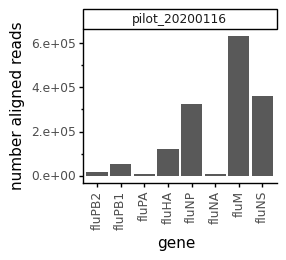

In [41]:
p = (ggplot(nreads_df, aes('gene', 'n_reads')) +
     geom_bar(stat='identity') +
     facet_wrap('~ sample', nrow=1) +
     theme(figure_size=(2.5 * len(samples_10x), 2),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format(),
                        name='number aligned reads')
     )

_ = p.draw()

### Fraction of reads that are gapped
Plot the fraction of all reads that are gapped for each viral gene:

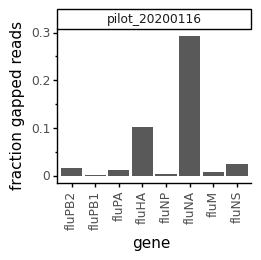

In [42]:
p = (ggplot(nreads_df.assign(frac=lambda x: x['n_gapped_reads'] / x['n_reads']),
            aes('gene', 'frac')) +
     geom_bar(stat='identity') +
     facet_wrap('~ sample', nrow=1) +
     theme(figure_size=(2.5 * len(samples_10x), 2),
           axis_text_x=element_text(angle=90)) +
     ylab('fraction gapped reads')
     )

_ = p.draw()

### Lengths of aligned reads for each viral gene
Plot the distribution of the lengths of the **aligned** portions of each read for each viral gene:

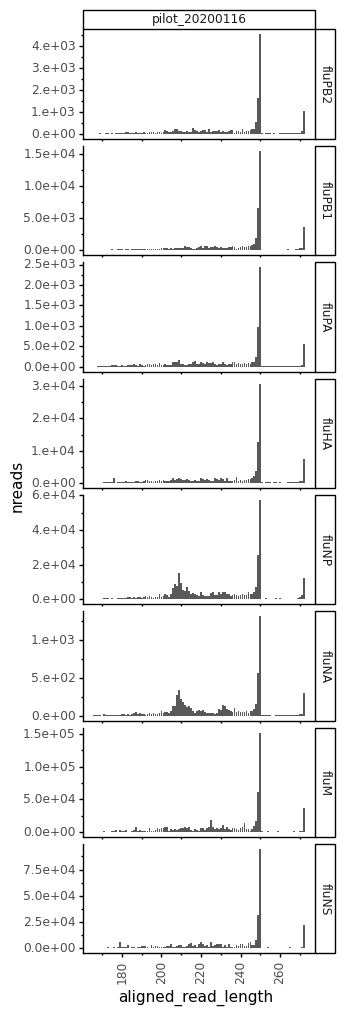

In [43]:
p = (ggplot(read_len_df, aes('aligned_read_length', 'nreads')) +
     geom_bar(stat='identity') +
     facet_grid('gene ~ sample', scales='free_y') +
     theme(figure_size=(3 * len(samples_10x), 1.5 * len(viral_gene_names)),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format())
     )

_ = p.draw()

### Plot estimated molecule sizes for each viral gene
Plot the distribution of the lengths of the **estimated** mRNA size for each viral gene. This assumes that all portions of the molecule which are not covered by a given read is ungapped.

In the plot below I increased the bar size to 50 nt, to make it easier to see the bars. There are many 

/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/positions/position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)


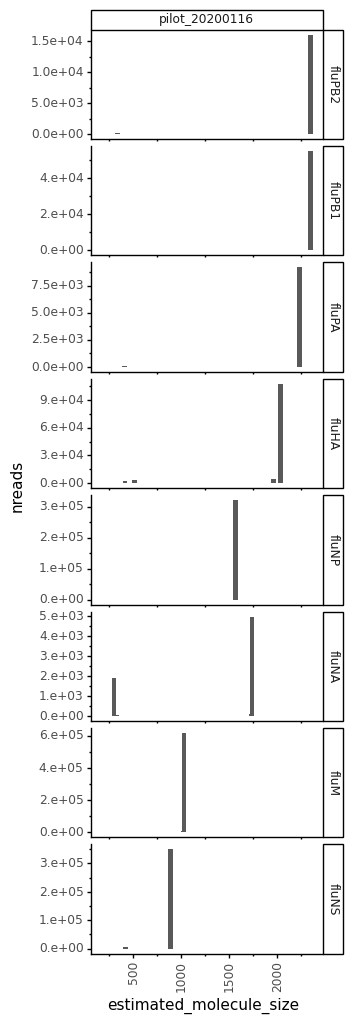

In [59]:
p = (ggplot(molecule_size_df, aes('estimated_molecule_size', 'nreads')) +
     geom_col(width=50) +
     facet_grid('gene ~ sample', scales='free_y') +
     theme(figure_size=(3 * len(samples_10x), 1.5 * len(viral_gene_names)),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format())
     )

_ = p.draw()

## Coverage per site, including over viral tags and barcodes
Now plot coverage per site alongside gene structure.
In this plot, we indicate the viral tags (blue) and viral barcodes (orange):

In [ ]:
fig, _ = plot_genes_and_coverage(viral_genes, coverage_df)

In the above plot, reads that align not at the 3' end have two likely causes:
 - Premature polyadenylation or mis-priming by oligo-dT primers cause the 3' primer to anneal before the end of the gene.
 - An internal deletion in the viral gene.

We can get some sense of these by plotting the coverage indicating observed mutations (an enrichment of `A` mutations before a peak could indicate the polyA explanation) and coverage only from the gapped reads (which could indicate an internal deletion in the viral gene).

First make the plot showing mutant nucleotides at each site:

In [ ]:
fig, _ = plot_genes_and_coverage(viral_genes, coverage_df, color_mutations=True)

Now plot coverage for **just** the gapped reads:

In [ ]:
fig, _ = plot_genes_and_coverage(viral_genes, gapped_coverage_df)

## Number of deletions in gapped reads
I want to see if gapped reads have just one gap, or multiple.

In [ ]:
p = (ggplot(gapped_reads_df, aes('num_deletions')) +
     geom_histogram(binwidth=1) +
     facet_wrap('~gene', nrow=1) +
     theme(figure_size=(2*len(gapped_reads_df['gene'].unique()), 2),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format(),
                        name='number of reads') +
     scale_x_continuous(name='number of gaps')
     )

_ = p.draw()